In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageEnhance
import torchvision.transforms as transforms

import os
from tqdm import tqdm


In [2]:
dir_train = 'D:\\dataset\\caltech_256_train'

# Load metadata

In [3]:
# train-val split 
M = pd.read_csv('train_val_split/train_metadata.csv')
V = pd.read_csv('train_val_split/val_metadata.csv')
decode = np.load('train_val_split/decode.npy')[()]

# Resize val. images

In [4]:
val_transform = transforms.Compose([
    transforms.Scale(224, Image.LANCZOS),
    transforms.CenterCrop(224)
])



C:\Users\quekai\Anaconda3\envs\ImageClassifier\lib\site-packages\torchvision\transforms\transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [5]:
val_size = len(V)
val_size

5140

In [6]:
val_images = np.zeros((val_size, 224, 224, 3), dtype='uint8')
val_targets = np.zeros((val_size,), dtype='int64')


In [7]:
# resize RGB images
for i, row in tqdm(V.loc[V.channels == 3].iterrows()):
    # get image
    file_path = os.path.join(dir_train, row.directory, row.img_name)
    image = Image.open(file_path)
    
    # transform it
    image = val_transform(image)
    
    # convert to array
    array = np.asarray(image, dtype='uint8')
    
    val_images[i] = array
    val_targets[i] = row.category_number



5066it [00:28, 178.59it/s]


In [8]:
# resize grayscale images
for i, row in tqdm(V.loc[V.channels == 1].iterrows()):
    file_path = os.path.join(dir_train, row.directory, row.img_name)
    image = Image.open(file_path)
    image = val_transform(image)
    array = np.asarray(image, dtype='uint8')
    # convert to RGB
    array = np.stack([array, array, array], axis=2)
    val_images[i] = array
    val_targets[i] = row.category_number



74it [00:00, 351.66it/s]


# Show some resized images

In [9]:
# choose random images
to_show = np.random.choice(np.arange(0, val_size), size=4*5, replace=False)


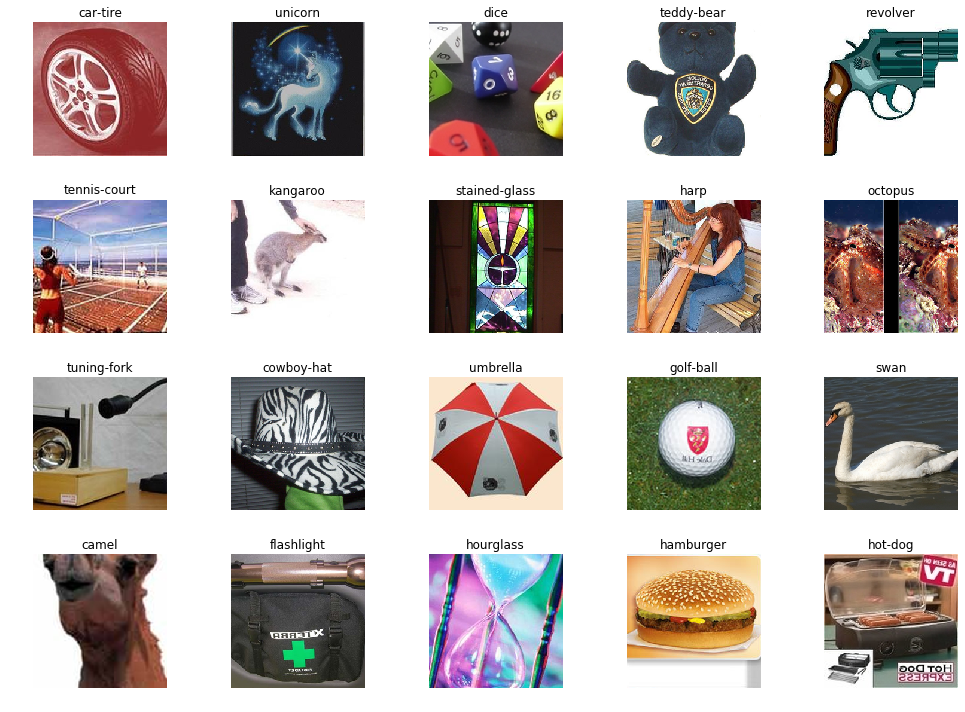

In [10]:
_, axes = plt.subplots(nrows=4, ncols=5, figsize=(14, 10))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(val_images[j]/255);
    axes[i].set_title(decode[val_targets[j]]);
plt.tight_layout()

# Explore imbalanced classes


In [11]:
(M.category_name.value_counts() > 100).mean()

0.0

In [12]:
class_counts = dict(M.category_name.value_counts())
np.save('class_counts.npy', class_counts)

# Resize train images

In [13]:
enhancers = {
    0: lambda image, f: ImageEnhance.Color(image).enhance(f),
    1: lambda image, f: ImageEnhance.Contrast(image).enhance(f),
    2: lambda image, f: ImageEnhance.Brightness(image).enhance(f),
    3: lambda image, f: ImageEnhance.Sharpness(image).enhance(f)
}

factors = {
    0: lambda: np.random.uniform(0.4, 1.6),
    1: lambda: np.random.uniform(0.8, 1.2),
    2: lambda: np.random.uniform(0.8, 1.2),
    3: lambda: np.random.uniform(0.4, 1.6)
}

def enhance(image):
    order = [0, 1, 2, 3]
    np.random.shuffle(order)
    for i in order:
        f = factors[i]()
        image = enhancers[i](image, f)
    return image



In [14]:
train_transform_rare = transforms.Compose([
    transforms.Scale(256, Image.LANCZOS),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(enhance)
])

train_transform = transforms.Compose([
    transforms.Scale(256, Image.LANCZOS),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
])

C:\Users\quekai\Anaconda3\envs\ImageClassifier\lib\site-packages\torchvision\transforms\transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [15]:
M = M.groupby('category_name', group_keys=False).apply(lambda x: x.sample(n=200, replace=True))
M.reset_index(drop=True, inplace=True)



In [16]:
train_size = len(M)
train_size

51400

In [17]:
train_images = np.zeros((train_size, 224, 224, 3), dtype='uint8')
train_targets = np.zeros((train_size,), dtype='int64')


In [18]:
# resize RGB images
for i, row in tqdm(M.loc[M.channels == 3].iterrows()):
    # get image
    file_path = os.path.join(dir_train, row.directory, row.img_name)
    image = Image.open(file_path)
    
    # transform it
    if class_counts[row.category_name] < 200:
        image = train_transform_rare(image)
    else:
        image = train_transform(image)
    
    # convert to array
    array = np.asarray(image, dtype='uint8')
    
    train_images[i] = array
    train_targets[i] = row.category_number

50653it [08:14, 102.46it/s]


In [19]:
# resize grayscale images
for i, row in tqdm(M.loc[M.channels == 1].iterrows()):
    file_path = os.path.join(dir_train, row.directory, row.img_name)
    image = Image.open(file_path)
    
    if class_counts[row.category_name] < 200:
        image = train_transform_rare(image)
    else:
        image = train_transform(image)
    
    array = np.asarray(image, dtype='uint8')
    # convert to RGB
    array = np.stack([array, array, array], axis=2)
    train_images[i] = array
    train_targets[i] = row.category_number



747it [00:05, 74.72it/s] 


# Show some resized images


In [20]:
# choose random images
to_show = np.random.choice(np.arange(0, train_size), size=4*5, replace=False)


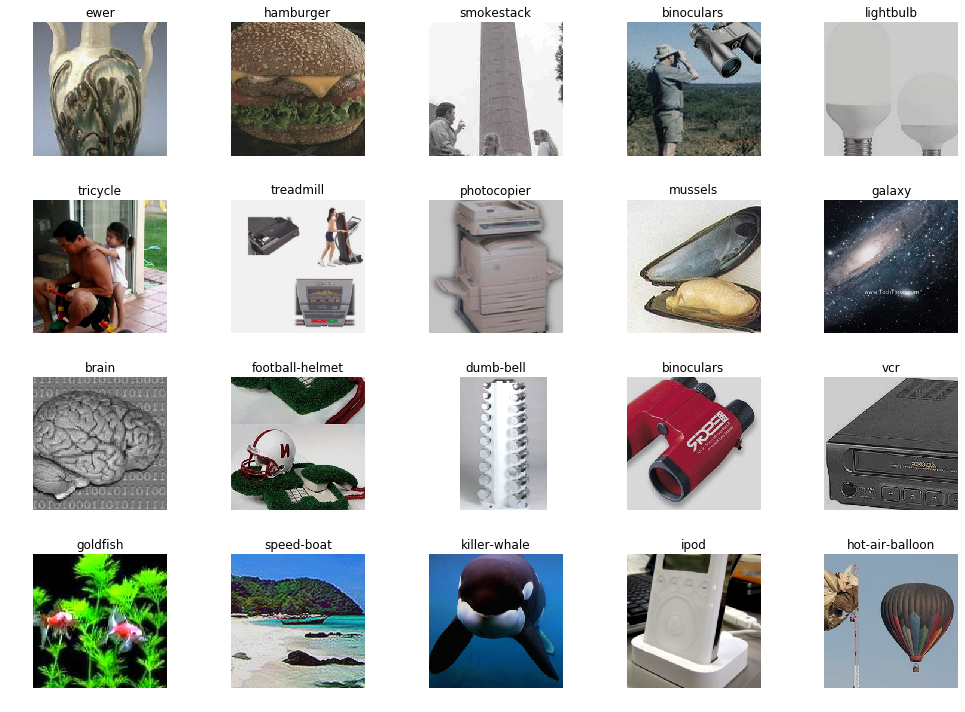

In [21]:
_, axes = plt.subplots(nrows=4, ncols=5, figsize=(14, 10))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(train_images[j]/255);
    axes[i].set_title(decode[train_targets[j]]);
plt.tight_layout()

In [22]:
# choose some random gray images
gray_indices = M.loc[M.channels == 1].index
to_show = np.random.choice(gray_indices, size=2*5, replace=False)

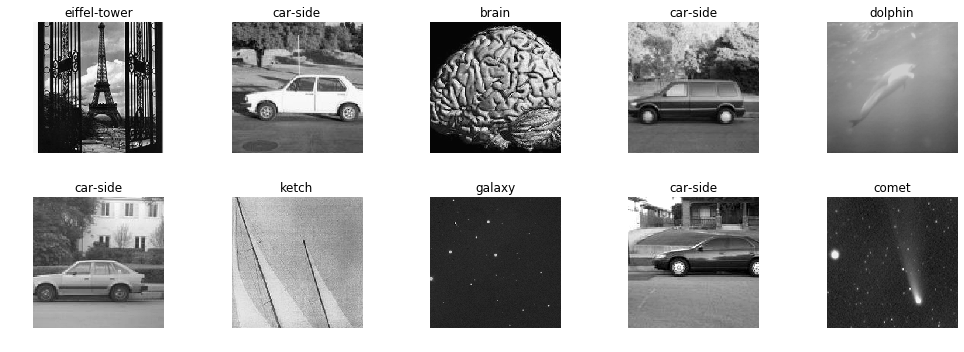

In [23]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 5))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(train_images[j]/255);
    axes[i].set_title(decode[train_targets[j]]);
plt.tight_layout()



In [24]:
# choose some random images from rare classes
rare_images = M.loc[M.category_name == 'scorpion'].index
to_show = np.random.choice(rare_images, size=8*5, replace=False)


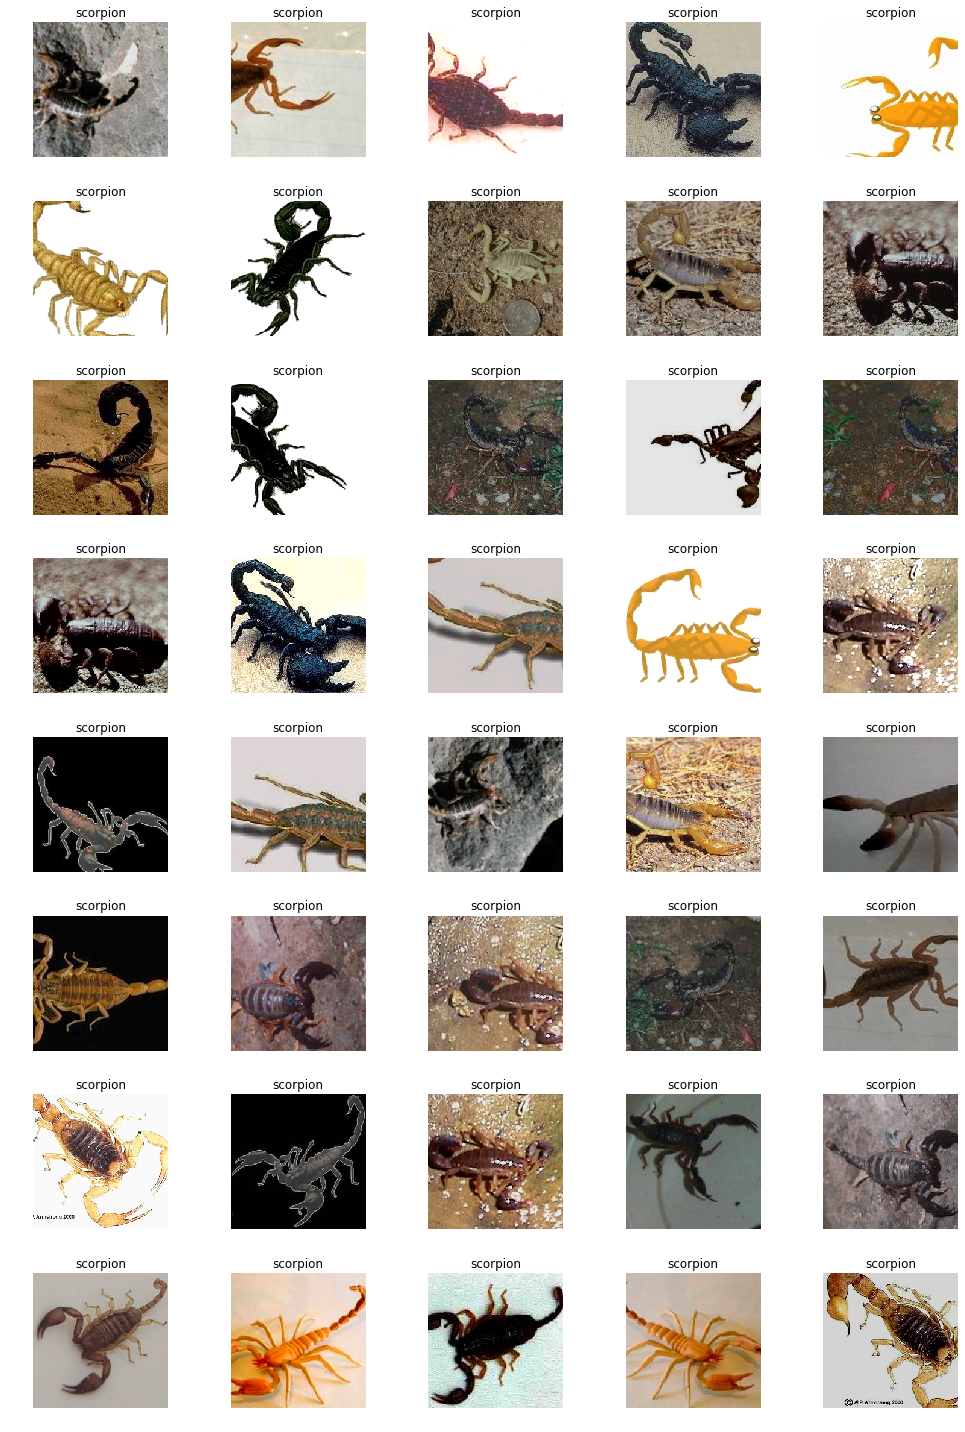

In [25]:
_, axes = plt.subplots(nrows=8, ncols=5, figsize=(14, 20))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(train_images[j]/255);
    axes[i].set_title(decode[train_targets[j]]);
plt.tight_layout()

In [26]:
# choose some random images from rare classes
rare_images = M.loc[M.category_name == 'skunk'].index
to_show = np.random.choice(rare_images, size=8*5, replace=False)




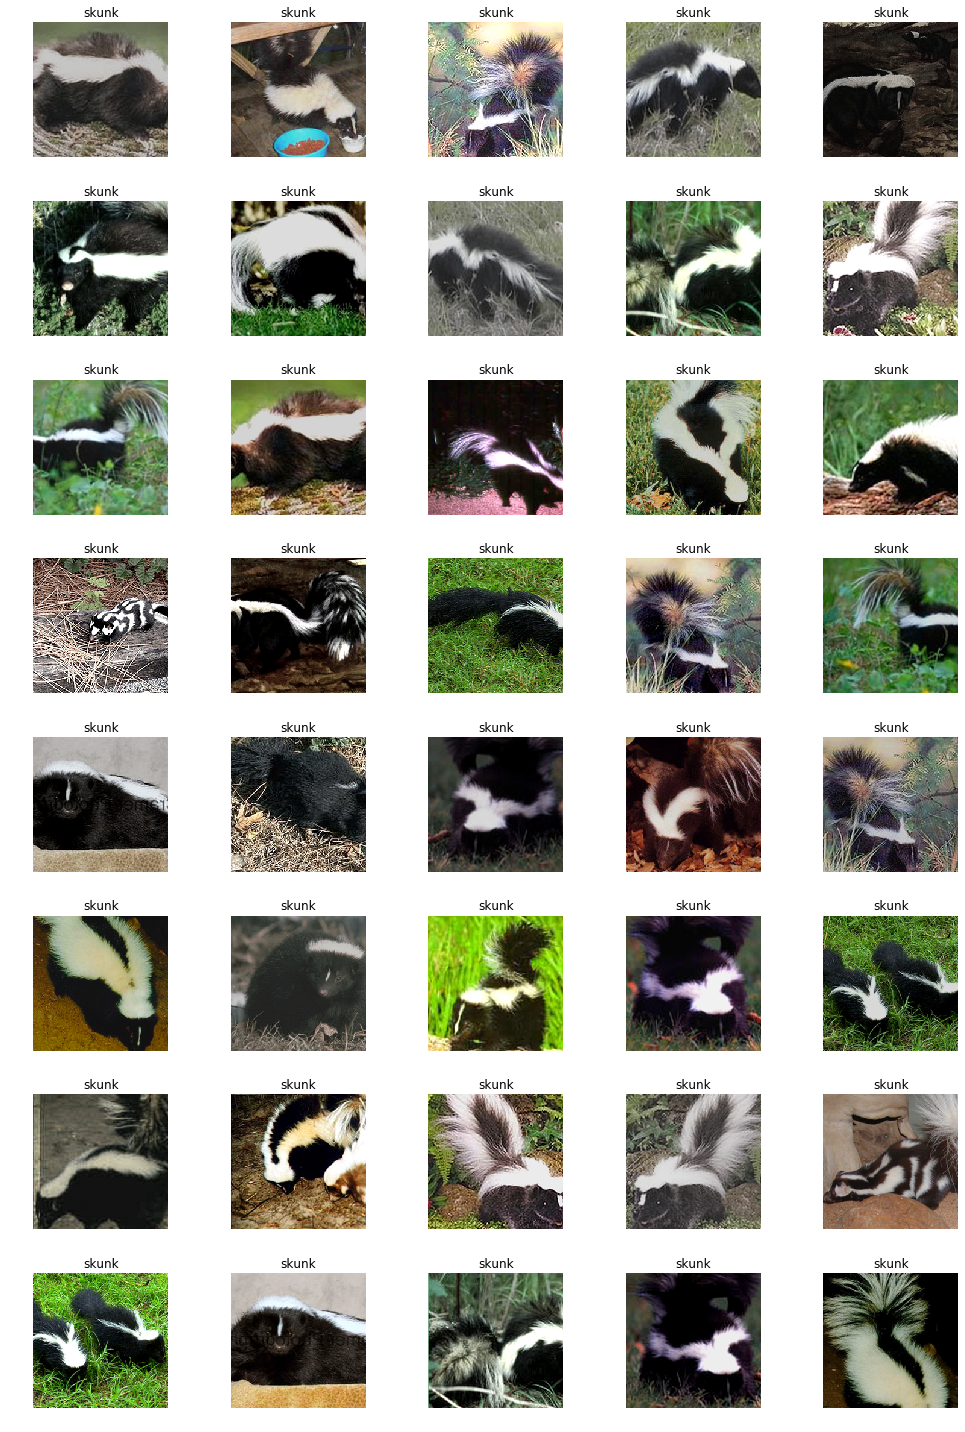

In [27]:
_, axes = plt.subplots(nrows=8, ncols=5, figsize=(14, 20))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(train_images[j]/255);
    axes[i].set_title(decode[train_targets[j]]);
plt.tight_layout()



# Save



In [28]:
%%time
np.save('data/train_images.npy', train_images) # size: 7.2 GB
np.save('data/train_targets.npy', train_targets)

np.save('data/val_images.npy', val_images) # size: 736 MB
np.save('data/val_targets.npy', val_targets)




Wall time: 7min 22s
